<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Training GAN for 2D Channel Reservoir

#### Honggeun Jo, Graduate Candidate, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/honggeun-jo/?originalSubdomain=kr) | [GitHub](https://github.com/whghdrms) | [Twitter](https://twitter.com/HonggeunJ)

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)


#### Workflow for Training GAN to Extract Major Patterns in 2D Subsurface Model 

This workflow demonstrate training of GAN [(Goodfellow et al., 2014)](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) for 2D channel reservoir. 

* the 2D channel reservoir models are generated from multipoint statistics (MPS), which is wildly used for facies modeling. 

* MPS uses a training image and mimics the main patterns in the training image to generates realizations through search tree algorithm. Details are [here](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2017WR021078).

#### Import Packages 

Fist of all, we need to load the required libraries, such as 

* [numpy](https://numpy.org/): To generate arrays <br>
* [matplotlib](https://matplotlib.org/): Vilsualization purpose <br>
* [tensorflow and Keras](https://www.tensorflow.org/learn): Design, compile and train neural network models
* os: to update working directory 
* time: to measrue compute time 

In [16]:
# Load library:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Change working directory, if needed:
# os.chdir(' ')

# This is for making directories where to save trained model and snapshots:
if os.path.isdir('Trained Models') == False:
    os.mkdir('Trained Models')
if os.path.isdir('Snapshots') == False:
    os.mkdir('Snapshots')

#### Load the Training Models

This includes the orginal training images and 500 MPS realization

Text(0, 0.5, 'Y axis, 100 ft')

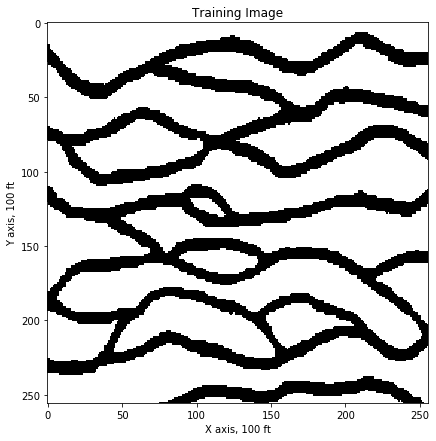

In [34]:
# Load both training image and MPS 500 MPS realizations 
Loaded_data = np.load('MPS_Training_image_and_Realizations_500.npz')
TI = Loaded_data['array1']
MPS_real = Loaded_data['array2']

# Visualizae Training image for 2D channel subsurface model:
plt.figure(figsize = (7,7))
plt.imshow(TI, cmap='binary')
plt.title('Training Image')
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

#### Visualize Multiple Realizations from MPS

Let's look at 9 realizations from the MPS simulation

Total Number of realizations: 500 
The dimension of each reservoir model: 128 x 128 in X and Y


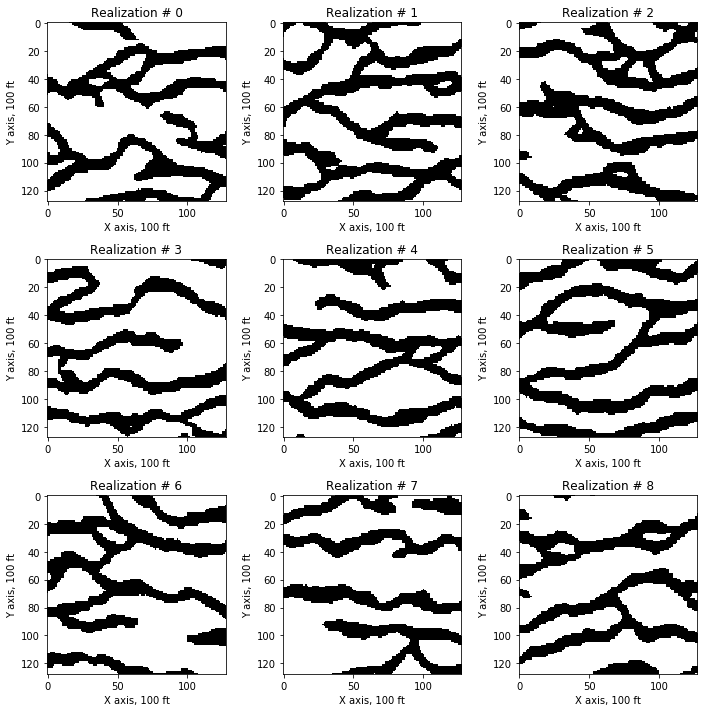

In [19]:
# Visualizae MPS realizations from the above training image:
print('Total Number of realizations: %d \nThe dimension of each reservoir model: %d x %d in X and Y' %(MPS_real.shape[2],MPS_real.shape[0], MPS_real.shape[1]))

plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(MPS_real[:,:,i], cmap='binary')
    plt.title('Realization # %d' %(i))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')
plt.tight_layout()

#### Step 1. Define convolutional neural networks for GAN (i.e., Generator and Discriminator)
First we need to define the structure of Generative adversarial network (GAN) to learn the main pattern from the above realizations. Following figure shows the schematic diagram of GAN. 

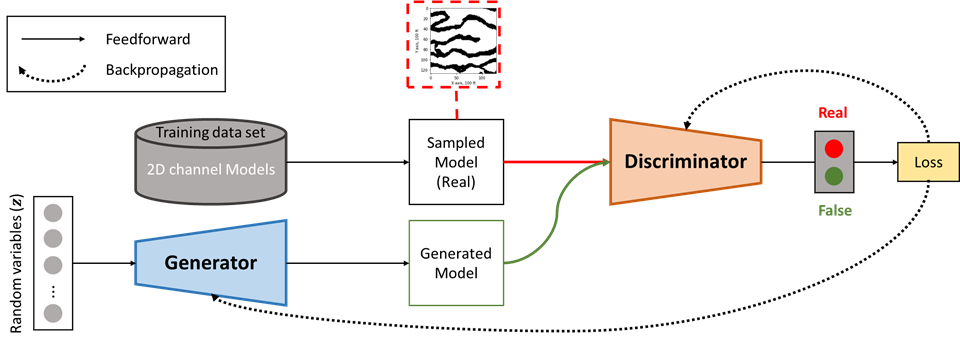

Here, both **Generator** and **Discriminator** are convolutional neural networks. 

* **Generator** maps a latent random vector (consists of 100 random variables that follow Gaussian, N(0,1)) to rule-based model whose dimension is 128 x 128 grid cells in x- and y- direction. 

* **Discriminator** takes a subsurface model (from either dataset or generator) and compute the probability the input model to be realistic (i.e., having major patterns within training dataset.) 

The following includes functions:

* **generator** - the convolutional neural network that makes new images

* **discriminator** - the convolutional neural network that takes images and accesses their probability that they came from the training image set

* **GAN** - the coupled generator and discriminator

* **train** - the procedure for training the GAN storing results

#### Import teh Tensorflow Packages Modules

We need additional package / modules for building the GAN

In [20]:
## Import the required packages for GAN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Be sure that you have tensorflow > 2.0 version
print(tf.__version__) 
assert tf.__version__.startswith('2.') # This will give you error if tensorflow < 2.0

# Default float to be 'float32' (So far, Tensorflow only works with float8, 16, 32)
tf.keras.backend.set_floatx('float32')

# Fix random seed for tensorflow / numpy 
tf.random.set_seed(77777)
np.random.seed(77777)

2.2.0


#### Load the Training Data

Load the training data

In [21]:
# Load training data
X_train = MPS_real.reshape(128,128,1,500).astype("float32")
X_train = np.moveaxis(X_train,-1,0)
# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### **Design Generator** Function

Design CNN to map a random latent vector (dimension of 100) to a image 

In [22]:
def make_generator_model():
    model = tf.keras.Sequential()
    # Feature map 1: 100 --> (8x8x64), where (width x height x # of channel)
    model.add(layers.Dense(8*8*64, input_shape=(100,)))  # This input dimension can be adjusted depends of the complexity
    model.add(layers.Reshape((8, 8, 64)))
    # Feature map 2: (8x8x64) --> (16x16x32)
    model.add(layers.Conv2DTranspose(32, kernel_size=(4, 4), strides=(2,2), padding = "same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    # Feature map 3: (16x16x32) --> (32x32x16)
    model.add(layers.Conv2DTranspose(16, kernel_size=(4, 4), strides=(2,2), padding = "same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    # Feature map 4: (32x32x16) --> (64x64x8)
    model.add(layers.Conv2DTranspose(8, kernel_size=(4, 4), strides=(2,2), padding = "same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    # Feature map 5: (64x64x8) --> (128x128x4)
    model.add(layers.Conv2DTranspose(4, kernel_size=(4, 4), strides=(2,2), padding = "same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.ReLU())
    # Feature map 6: (128x128x4) --> (128x128x1)
    model.add(layers.Conv2D(1, kernel_size=(3,3), padding="same", activation = 'sigmoid'))
    return model

#### **Design Discriminator** Function

Design CNN to map a image to the likelihood to be true. (output = 1 if real, 0 otherwise) 

In [23]:
def make_discriminator_model():
    # define neural network model sequentially
    model = tf.keras.Sequential()
    # Feature map 1: (128x128x1) --> (64x64x8)
    model.add(layers.Conv2D(8, kernel_size=(3,3), strides=2, input_shape=[128,128,1], padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    # Feature map 2: (64x64x8) --> (32x32x16)
    model.add(layers.Conv2D(16, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    # Feature map 3: (32x32x16) --> (16x16x32)
    model.add(layers.Conv2D(32, kernel_size=(3,3), strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    # Feature map 4: (16x16x32) --> (8x8x64)
    model.add(layers.Conv2D(64, kernel_size=(3,3), strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    # Feature map 5: (8x8x64) --> 1 (either 1 (for real) or 0 (for fake))
    model.add(layers.Dense(1,activation = 'sigmoid'))

    return model

#### Define the Loss and Optimizers

In [24]:
## Define the loss and optimizers
# Loss fuction of GAN:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# Optimier of Generator and Discriminator (both "Adam")
generator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002,0.5)

#### Instantiate the Generator and Descriminator

In [26]:
# Instantiate generator and discriminator
generator = make_generator_model()
discriminator =  make_discriminator_model()

In [27]:
# Define number of epochs with seed to visualize training process
EPOCHS = 1001
noise_dim = 100
num_examples_to_generate = 25
# We will reuse this seed overtime to visualize progress in the animated GIF
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [28]:
## Define fuctions to train GAN
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Noise (i.e., latent random variables) for fake images 
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # ------------------------------------------------
    # 0. Compute of loss in generator and discriminator
    # ------------------------------------------------
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generator random images
        generated_images = generator(noise, training=True)
        # output of discriminator when feeding real images
        real_output = discriminator(images, training=True)
        # output of discriminator when feeding fake images
        fake_output = discriminator(generated_images, training=True)
        # Compute both loss of generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # ------------------------------------------------
    # 1. Update Generator
    # ------------------------------------------------
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    # ------------------------------------------------
    # 2. Update Discriminator
    # ------------------------------------------------
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    start = time.time() 
    for epoch in range(epochs):
        # Train GAN on Batches
        for image_batch in dataset:
            train_step(image_batch)
        # Save the model every 50 epochs
        if (epoch) % 10 == 0:
            save_model(generator, epoch)
            save_imgs(generator, epoch, test_input = seed)
            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
            start = time.time()

# This is to save snapshot of images from generator
def save_imgs(generator, epoch, test_input):
    # r, c = row and columns of the subplot
    r, c = 5, 5
    noise = test_input
    # Generate 25 new images with the given seed
    gen_imgs = generator(noise, training=False)
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='binary')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("Snapshots/MPS_epoch_%d.png" % epoch)
    plt.close()

# This is to save the trained generators
def save_model(generator, epoch):
    generator.save('Trained Models/Generator_Epoch_%d.h5' % epoch)


In [29]:
# Train GAN
train(train_dataset, EPOCHS)

Time for epoch 1 is 7.858727931976318 sec
Time for epoch 11 is 54.5775191783905 sec
Time for epoch 21 is 54.31007122993469 sec
Time for epoch 31 is 54.637155294418335 sec
Time for epoch 41 is 53.879329204559326 sec
Time for epoch 51 is 53.44173836708069 sec
Time for epoch 61 is 54.05907607078552 sec
Time for epoch 71 is 53.762322425842285 sec
Time for epoch 81 is 53.43417000770569 sec
Time for epoch 91 is 53.391350746154785 sec
Time for epoch 101 is 53.309579610824585 sec
Time for epoch 111 is 53.35768151283264 sec
Time for epoch 121 is 53.33362174034119 sec
Time for epoch 131 is 53.48198366165161 sec
Time for epoch 141 is 53.78057861328125 sec
Time for epoch 151 is 53.945958375930786 sec
Time for epoch 161 is 54.82622718811035 sec
Time for epoch 171 is 54.399144411087036 sec
Time for epoch 181 is 54.4694037437439 sec
Time for epoch 191 is 55.0897536277771 sec
Time for epoch 201 is 54.86292004585266 sec
Time for epoch 211 is 55.217280626297 sec
Time for epoch 221 is 55.60820126533508 s

#### Step 2. Load the trainined GAN 

Now we load the trained generator and compare GAN realizations with MPS models. 

* First we will do visual inspection on both models depending on GAN's training process. 

* After that, we will use multi-dimensional scaling to visualize reservoir models in 2D space and analyze similarity between MPS and GAN realizations.

In [14]:
from tensorflow.keras.models import load_model # this is for loading NN models 

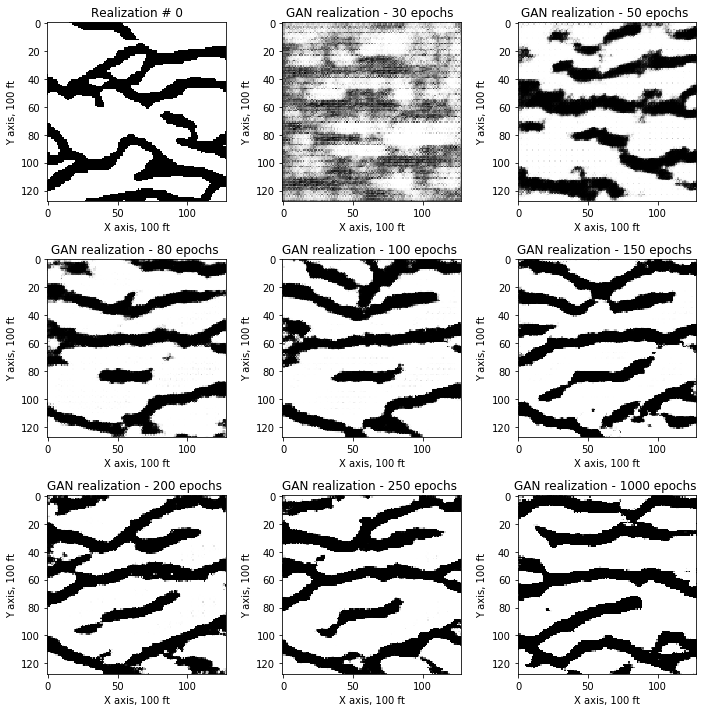

In [30]:
# Visual insepction
plt.figure(figsize = (10,10))
plt.subplot(3,3,1)
plt.imshow(MPS_real[:,:,0], cmap='binary')
plt.title('Realization # %d' %(0))
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

epochs = [0, 30, 50, 80, 100, 150, 200, 250, 1000]
fixed_noise = np.random.normal(0,1,(1,100))
for i in range(1,9):
    plt.subplot(3,3,i+1)
    Generator = load_model('Trained Models/Generator_Epoch_%d.h5' % epochs[i], compile = False)
    GAN_realization = Generator.predict(fixed_noise).reshape(128,128)
    plt.imshow(GAN_realization, cmap='binary')
    plt.title('GAN realization - %d epochs ' %(epochs[i]))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')

plt.tight_layout()

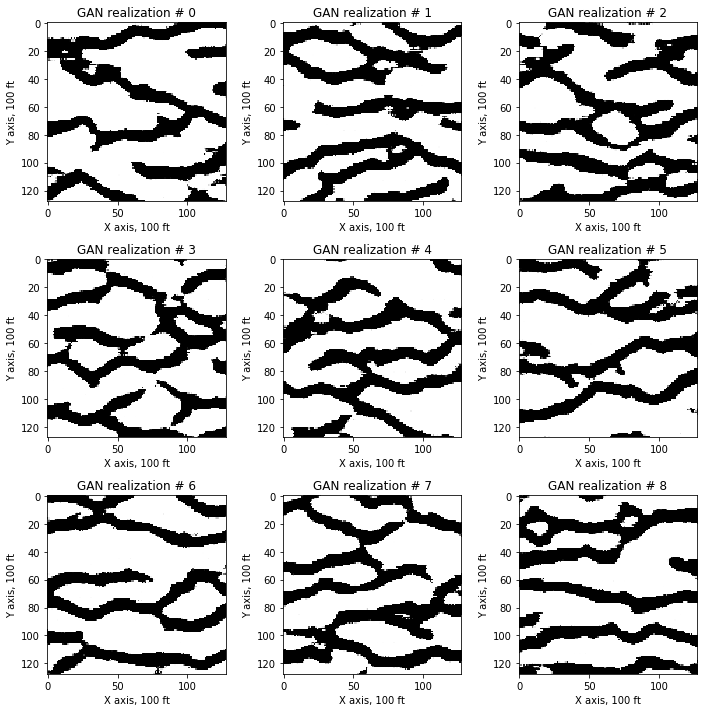

In [32]:
# Load Generator
Generator = load_model('Trained Models/Generator_Epoch_1000.h5', compile = False)
GAN_realization = Generator.predict(np.random.normal(0,1,(9,100))).reshape(9,128,128)

plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(GAN_realization[i, :,:], cmap='binary')
    plt.title('GAN realization # %d' %(i))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')
plt.tight_layout()

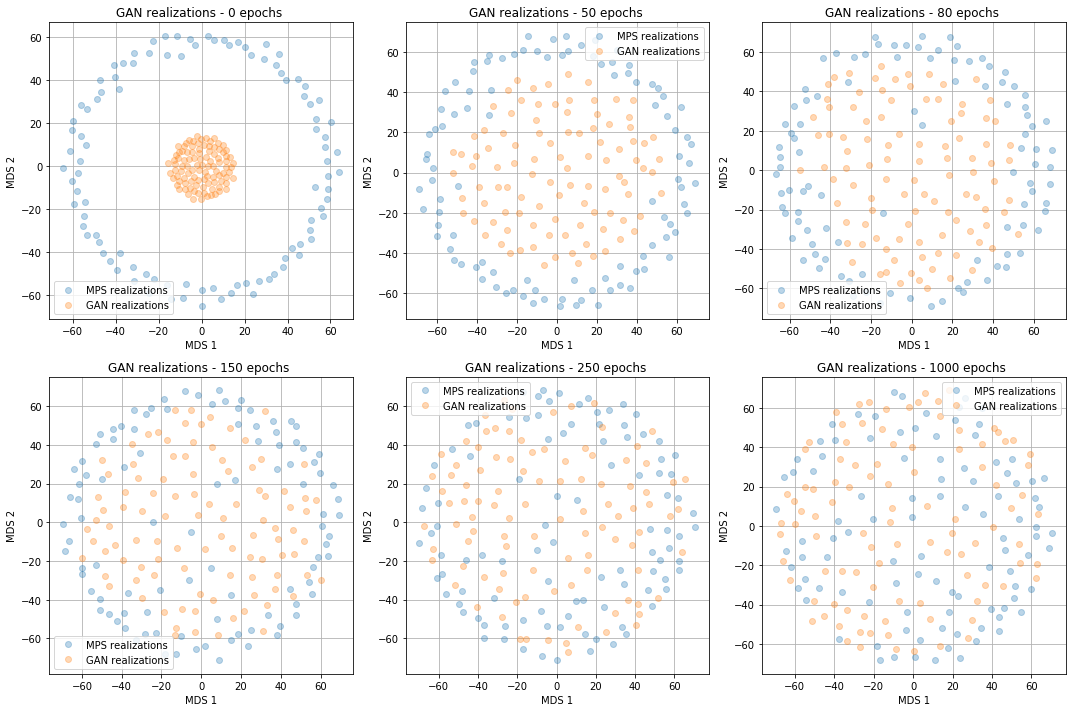

In [33]:
# Visualize similarity in 2D space (MDS)
from sklearn.manifold import MDS
mds = MDS(random_state=123)
MPS_realizations = X_train.reshape(500,-1)[:100]

plt.figure(figsize=(15,10))
epochs = [0,50,80,150,250,1000]
for i in range(6):
    # Map to 2D space
    Generator = load_model('Trained Models/Generator_Epoch_%d.h5' % epochs[i], compile = False)
    GAN_realizations = Generator.predict(np.random.normal(0,1,(100,100))).reshape(100,-1)
    mds_array = np.concatenate([MPS_realizations, GAN_realizations], axis = 0)
    mds_2D = mds.fit_transform(mds_array)
    
    plt.subplot(2,3,i+1)
    plt.plot(mds_2D[:100,0],mds_2D[:100,1],'o', alpha = 0.3, label = 'MPS realizations')
    plt.plot(mds_2D[100:,0],mds_2D[100:,1],'o', alpha = 0.3, label = 'GAN realizations')
    plt.title('GAN realizations - %d epochs ' %(epochs[i]))
    plt.grid('on')
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    plt.legend()
    
plt.tight_layout()

#### Benefits of using GAN for subsurface models

1. We can represent realizations with the smaller number of numeric values (~100). **Dimensionality reduction**.
2. ...which means we can now represent qualitative information (we had in training dataset) using quantitative values.
3. As we can represent realizations with a numeric expression, we can easily apply optimization or history matching to GAN realization. 
4. GAN gaurantees that any new realizations conserve the major geological pattern we had in training dataset. **Navigation in manifold**.
5. Flexibility of GAN enable expanding its application to any type of subsurface model (e.g., 3D, channel, lobe, detaic, etc)

#### Comments

The Texas Center for Geostatistics has many other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available [here](https://github.com/GeostatsGuy/PythonNumericalDemos), along with a package for geostatistics in Python called [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy). 
  
We hope this was helpful,

*Michael* and *Honggeun*

***

#### More on Michael Pyrcz and the Texas Center for Data Analytics and Geostatistics:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### for any further comments or questions, please contact Dr. Pyrcz via mpyrcz@austin.utexas.edu